### Requirements

Please install the following packages

`pip3 install scikit-learn`

`pip3 install tensorflow`

`pip3 install matplotlib`

`pip3 install gym`

In [1]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import warnings
import random

## Stocastic Gradient Descent

Suppose there was some true function: $y = w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{3} + w_{4}x_{4} + w_{5}x_{5}$. We create random weights for this fuction, and try to find them through SGD. Go ahead and change the true weights! See what happens when you change the learning rate. 

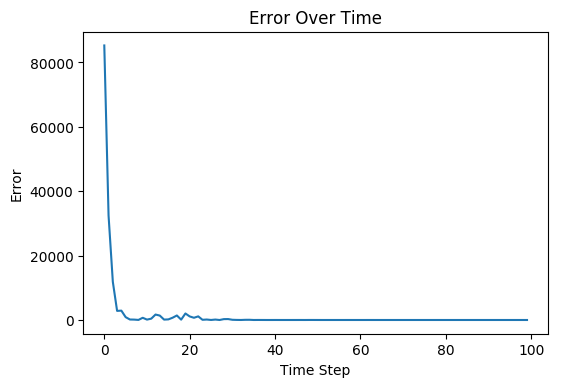

In [5]:
true_weights = np.array([20, 10, 15, 2, 1])
predicted_weights = np.zeros(len(true_weights))
errors = []
for i in range(100):
    point = np.random.randint(0, 10, len(true_weights))

    y_true = np.dot(point, true_weights)
    y_predicted = np.dot(point, predicted_weights)

    difference = y_predicted - y_true
    errors.append((y_predicted - y_true)**2)

    predicted_weights -= 0.01 * difference * point

plt.figure(dpi = 100)
plt.plot(errors)
plt.title('Error Over Time')
plt.ylabel('Error')
plt.xlabel('Time Step')
plt.show()


## Neural Networks

Let's build a neural network to classify the MNIST dataset. 

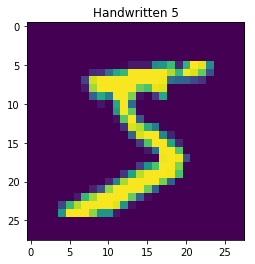

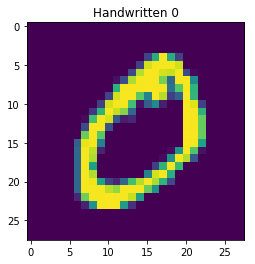

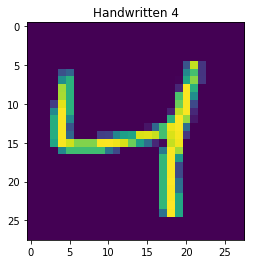

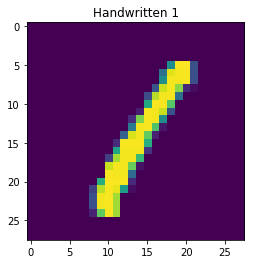

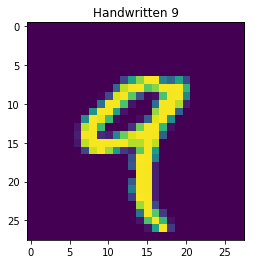

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(float) - np.mean(x_train))/np.std(x_train)
x_test = (x_test.astype(float) - np.mean(x_test))/np.std(x_test)

for i in range(5):
  plt.imshow(x_train[i])
  plt.title(f'Handwritten {y_train[i]}')
  plt.show()

In [7]:
x_train = x_train.reshape(-1, 784)
x_test= x_test.reshape(-1, 784)

# one-hot encoding:
encoder = OneHotEncoder(categories='auto')
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

tf.logging.set_verbosity(tf.logging.ERROR)
nn = Sequential()
nn.add(Dense(100, activation = 'relu'))
nn.add(Dense(10, activation = 'softmax'))
nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = nn.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 3)
print (nn.summary())

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 8s 128us/sample - loss: 0.2327 - acc: 0.9302 - val_loss: 0.1380 - val_acc: 0.9599
Epoch 2/3
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1084 - acc: 0.9663 - val_loss: 0.1099 - val_acc: 0.9659
Epoch 3/3
60000/60000 [==============================] - 7s 110us/sample - loss: 0.0791 - acc: 0.9748 - val_loss: 0.0968 - val_acc: 0.9709
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  78500     
_________________________________________________________________
dense_1 (Dense)              multiple                  1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


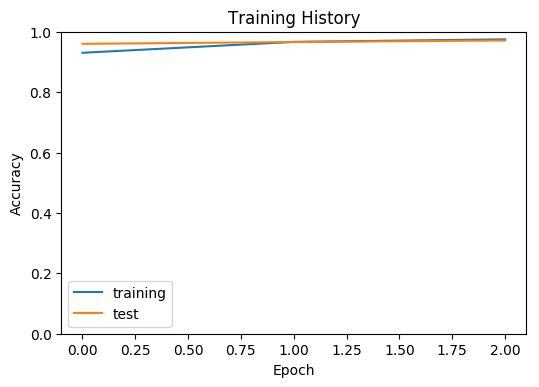

In [9]:
plt.figure(dpi = 100)
plt.plot(history.history['acc'], label = 'training')
plt.plot(history.history['val_acc'], label = 'test')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.xlabel('Epoch')
plt.legend()
plt.show()